In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold

In [20]:
result_path = '/Volumes/KINGSTON/Orion/Cytotox_HCA_reference_dataset_results_EC50_LEC_CLASSES.csv'
compounds_path = '/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1'
# label_path = '/Users/ruijingyang/VSProjects/Orion-Cytox/src/cytotoxicity/data/compound_label_barcode_mapping.csv'
labels_path = '/Users/ruijingyang/VSProjects/Orion-Cytox/src/cytotoxicity/data/compounds_lables.txt'

In [3]:
plate_df = pd.read_csv('/Users/ruijingyang/VSProjects/Orion-Cytox/src/cytotoxicity/data/Cytotox_HCA_065_20230907_B0_plate_map.csv', skiprows=21, nrows=16, header=None)
plate_df.head()


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,A,ORM-0364078,ORM-0364078,ORM-0364074,ORM-0364074,ORM-0049279,ORM-0049279,ORM-0120988,ORM-0120988,ORM-0140940,...,ORM-0178130,ORM-0178130,ORM-0226420,ORM-0226420,DMSO,DMSO,DMSO,DMSO,Rotenone,Rotenone
1,B,ORM-0364078,ORM-0364078,ORM-0364074,ORM-0364074,ORM-0049279,ORM-0049279,ORM-0120988,ORM-0120988,ORM-0140940,...,ORM-0178130,ORM-0178130,ORM-0226420,ORM-0226420,DMSO,DMSO,DMSO,DMSO,Rotenone,Rotenone
2,C,ORM-0364078,ORM-0364078,ORM-0364074,ORM-0364074,ORM-0049279,ORM-0049279,ORM-0120988,ORM-0120988,ORM-0140940,...,ORM-0178130,ORM-0178130,ORM-0226420,ORM-0226420,DMSO,DMSO,DMSO,DMSO,Rotenone,Rotenone
3,D,ORM-0364078,ORM-0364078,ORM-0364074,ORM-0364074,ORM-0049279,ORM-0049279,ORM-0120988,ORM-0120988,ORM-0140940,...,ORM-0178130,ORM-0178130,ORM-0226420,ORM-0226420,DMSO,DMSO,DMSO,DMSO,Rotenone,Rotenone
4,E,ORM-0364078,ORM-0364078,ORM-0364074,ORM-0364074,ORM-0049279,ORM-0049279,ORM-0120988,ORM-0120988,ORM-0140940,...,ORM-0178130,ORM-0178130,ORM-0226420,ORM-0226420,DMSO,DMSO,DMSO,DMSO,Rotenone,Rotenone


In [40]:
plate_df.iloc[0][1:21].tolist()

['ORM-0364078',
 'ORM-0364078',
 'ORM-0364074',
 'ORM-0364074',
 'ORM-0049279',
 'ORM-0049279',
 'ORM-0120988',
 'ORM-0120988',
 'ORM-0140940',
 'ORM-0140940',
 'ORM-0140942',
 'ORM-0140942',
 'ORM-0149820',
 'ORM-0149820',
 'ORM-0178130',
 'ORM-0178130',
 'ORM-0226420',
 'ORM-0226420',
 'DMSO']

### check how to split one compound to 4 videos

In [71]:
import re
import glob

In [67]:
comp_path = '/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1/ORM-0283845_230817GA24A0'
image_list = os.listdir(comp_path)

### find min max column

In [74]:
def find_comp_column_range(directory):
    pattern = re.compile(r'001(\d{3})-\d-00100100\d\.tif')

    # 存储所有解析出的column值
    columns = []

    # 遍历目录中的所有文件
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            # 将匹配到的column部分添加到列表中
            column = int(match.group(1))
            # print(column)
            columns.append(column)

    # 如果columns列表不为空，计算最小和最大值
    if columns:
        min_column = min(columns)
        max_column = max(columns)
        return min_column, max_column
    else:
        return None, None

In [86]:
def group_images(directory, columns, views):
    # 初始化一个字典来存储分组
    groups = [] #{}

    # 构建正则表达式模式来匹配文件名
    pattern = re.compile(r'(\d{3})(\d{3})-(\d)-001001(\d{3}).tif')
    
    # 遍历指定的column和view组合
    for column in columns:
        for view in views:
            # 使用glob来查找匹配特定column和view的所有文件
            path_pattern = f"{directory}/*{column}-{view}-*.tif"
            files = glob.glob(path_pattern)
            
            # 添加到字典中，键为(column, view)
            if files:  # 确保列表不为空
                # groups[(column, view)] = files
                groups.append(files)

    return groups

In [75]:
min_column, max_column = find_comp_column_range(comp_path)

In [76]:
columns = [min_column, max_column]
views = [1, 2]

In [87]:
if min_column is not None and max_column is not None:
    print(f"The range of columns in the files is from {min_column} to {max_column}.")
    groups = group_images(comp_path, columns, views)
    
else:
    print("No valid column data found in filenames.")

The range of columns in the files is from 11 to 12.


In [97]:
all_groups = []

In [99]:
all_groups.extend(groups)
all_groups

[['/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1/ORM-0283845_230817GA24A0/001011-1-001001001.tif',
  '/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1/ORM-0283845_230817GA24A0/001011-1-001001002.tif',
  '/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1/ORM-0283845_230817GA24A0/001011-1-001001003.tif',
  '/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1/ORM-0283845_230817GA24A0/001011-1-001001004.tif',
  '/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1/ORM-0283845_230817GA24A0/001011-1-001001005.tif',
  '/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1/ORM-0283845_230817GA24A0/002011-1-001001001.tif',
  '/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1/ORM-0283845_230817GA24A0/002011-1-001001002.tif',
  '/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1/ORM-0283845_230817GA24A0/002011-1-001001003.tif',
  '/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1/ORM-0283845_230817GA24A0/002011-1-001001004.tif',
  '/Volumes/KINGSTON/Orion/r

In [100]:
len(all_groups)

8

In [103]:
all_groups[5][0]

'/Volumes/KINGSTON/Orion/reference_dataset_compounds_v1/ORM-0283845_230817GA24A0/001011-2-001001001.tif'

In [114]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

In [115]:
# img = cv2.imread(all_groups[5][0], 0)
img = mpimg.imread(all_groups[5][0])

In [124]:
img

array([[320, 421, 359, ..., 289, 340, 256],
       [314, 290, 294, ..., 296, 259, 329],
       [331, 373, 307, ..., 348, 290, 299],
       ...,
       [294, 248, 273, ..., 361, 335, 311],
       [299, 302, 273, ..., 312, 356, 347],
       [266, 264, 240, ..., 371, 321, 317]], dtype=uint16)

In [125]:
image = (img - 127.5)/128

In [126]:
image

array([[1.50390625, 2.29296875, 1.80859375, ..., 1.26171875, 1.66015625,
        1.00390625],
       [1.45703125, 1.26953125, 1.30078125, ..., 1.31640625, 1.02734375,
        1.57421875],
       [1.58984375, 1.91796875, 1.40234375, ..., 1.72265625, 1.26953125,
        1.33984375],
       ...,
       [1.30078125, 0.94140625, 1.13671875, ..., 1.82421875, 1.62109375,
        1.43359375],
       [1.33984375, 1.36328125, 1.13671875, ..., 1.44140625, 1.78515625,
        1.71484375],
       [1.08203125, 1.06640625, 0.87890625, ..., 1.90234375, 1.51171875,
        1.48046875]])

In [123]:
cv2.imread(all_groups[5][0], 0).shape

(1080, 1080)

In [121]:
xx = cv2.imread(all_groups[5][0])
xx.shape

(1080, 1080, 3)

In [118]:
type(img)

numpy.ndarray

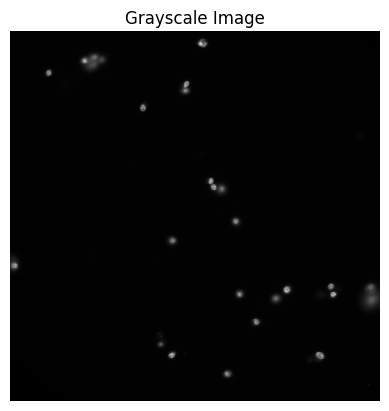

In [117]:
plt.imshow(img, cmap='gray')  # Set the color map to 'gray' for grayscale
plt.title('Grayscale Image')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

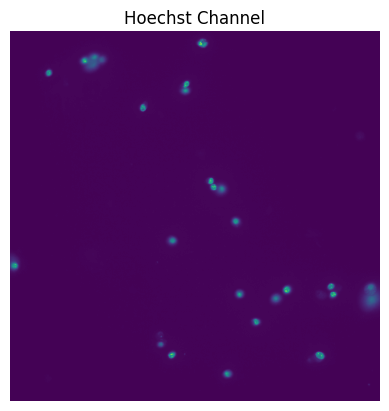

In [111]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
plt.title('Hoechst Channel')
plt.axis('off')
plt.show()

In [101]:
[1] * len(groups)

[1, 1, 1, 1]

In [94]:
len(groups[0])

80

In [92]:
for i, group in enumerate(groups):
    print(len(group))

80
80
80
80


In [69]:
sorted(image_list)

['001011-1-001001001.tif',
 '001011-1-001001002.tif',
 '001011-1-001001003.tif',
 '001011-1-001001004.tif',
 '001011-1-001001005.tif',
 '001011-2-001001001.tif',
 '001011-2-001001002.tif',
 '001011-2-001001003.tif',
 '001011-2-001001004.tif',
 '001011-2-001001005.tif',
 '001012-1-001001001.tif',
 '001012-1-001001002.tif',
 '001012-1-001001003.tif',
 '001012-1-001001004.tif',
 '001012-1-001001005.tif',
 '001012-2-001001001.tif',
 '001012-2-001001002.tif',
 '001012-2-001001003.tif',
 '001012-2-001001004.tif',
 '001012-2-001001005.tif',
 '002011-1-001001001.tif',
 '002011-1-001001002.tif',
 '002011-1-001001003.tif',
 '002011-1-001001004.tif',
 '002011-1-001001005.tif',
 '002011-2-001001001.tif',
 '002011-2-001001002.tif',
 '002011-2-001001003.tif',
 '002011-2-001001004.tif',
 '002011-2-001001005.tif',
 '002012-1-001001001.tif',
 '002012-1-001001002.tif',
 '002012-1-001001003.tif',
 '002012-1-001001004.tif',
 '002012-1-001001005.tif',
 '002012-2-001001001.tif',
 '002012-2-001001002.tif',
 

### check the problem compound

In [52]:
testpath = '/Volumes/KINGSTON/Orion/reference_dataset_imaging_TIFFs/230817GA24B0/2023-08-18T110656+0300[4772]/2023-08-18T110656+0300[4772]' #'/Volumes/KINGSTON/Orion/reference_dataset_imaging_TIFFs_processed/230817GA24B0'
import re


In [59]:
pattern = r'0\d{2}009-\d-\d{9}\.tif'

In [60]:
count = 0
for filename in os.listdir(testpath):
    # 检查文件名是否匹配给定的正则表达式模式
    if re.match(pattern, filename):
        count += 1

count

160

### Check the numbers of images per compound

In [24]:
folder_counts = {}

# 遍历指定目录的每个直接子目录
for folder_name in os.listdir(compounds_path):
    folder_path = os.path.join(compounds_path, folder_name)
    if os.path.isdir(folder_path):  # 确保是文件夹
        # 计算当前文件夹内的文件数量
        count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
        folder_counts[folder_name] = count

In [25]:
from collections import Counter

In [26]:
Counter(folder_counts)

Counter({'ORM-0293893_230907GA24A0': 320,
         'ORM-0293899_230907GA24A0': 320,
         'ORM-0293923_230907GA24A0': 320,
         'ORM-0294024_230907GA24A0': 320,
         'ORM-0294172_230907GA24A0': 320,
         'ORM-0364075_230907GA24A0': 320,
         'ORM-0364082_230907GA24A0': 320,
         'ORM-0001602_230907GA24A0': 320,
         'ORM-0013271_230907GA24A0': 320,
         'ORM-0272079_230907GA24A0': 320,
         'DMSO_230907GA24A0': 320,
         'ORM-0002393_240219GA24A0': 320,
         'ORM-0006484_240219GA24A0': 320,
         'ORM-0006948_240219GA24A0': 320,
         'ORM-0010450_240219GA24A0': 320,
         'ORM-0013271_240219GA24A0': 320,
         'ORM-0014500_240219GA24A0': 320,
         'ORM-0120988_240219GA24A0': 320,
         'ORM-0158218_240219GA24A0': 320,
         'ORM-0260776_240219GA24A0': 320,
         'ORM-0292982_240219GA24A0': 320,
         'DMSO_240219GA24A0': 320,
         'DMSO_230907GA24B0': 480,
         'ORM-0292997_240219GA24B0': 320,
         'ORM

### generate cross validation folds

In [4]:
labels_df = pd.read_csv(labels_path, index_col=None, header=None)
labels_df

,0,1
0,ORM-0012859_230810GA24B0,1
1,ORM-0013025_230810GA24B0,1
2,ORM-0013050_230810GA24B0,1
3,ORM-0006315_230810GA24B0,1
4,ORM-0012312_230810GA24B0,1
...,...,...
135,DMSO_240219GA24A0,0
136,DMSO_230817GA24A0,0
137,DMSO_230831GA24C0,0
138,DMSO_230831GA24A0,0


In [17]:
# labels_df.loc[labels_df[0] == 'ORM-0012312_230810GA24B0', 1].values[0]

1

In [5]:
labels_df[0].tolist()

['ORM-0012859_230810GA24B0',
 'ORM-0013025_230810GA24B0',
 'ORM-0013050_230810GA24B0',
 'ORM-0006315_230810GA24B0',
 'ORM-0012312_230810GA24B0',
 'ORM-0013348_230810GA24B0',
 'ORM-0140942_230810GA24C0',
 'ORM-0120988_230810GA24C0',
 'ORM-0178130_230810GA24C0',
 'ORM-0049279_230810GA24C0',
 'ORM-0149820_230810GA24C0',
 'ORM-0280627_230817GA24A0',
 'ORM-0283845_230817GA24A0',
 'ORM-0178132_230817GA24A0',
 'ORM-0293290_230817GA24A0',
 'ORM-0226420_230817GA24A0',
 'ORM-0260776_230817GA24A0',
 'ORM-0274325_230817GA24A0',
 'ORM-0293612_230817GA24B0',
 'ORM-0293831_230817GA24B0',
 'ORM-0294024_230817GA24C0',
 'ORM-0293899_230817GA24C0',
 'ORM-0293893_230817GA24C0',
 'ORM-0364075_230817GA24C0',
 'ORM-0272079_230817GA24C0',
 'ORM-0294172_230817GA24C0',
 'ORM-0292987_230824GA24B0',
 'ORM-0126653_230824GA24B0',
 'ORM-0293334_230824GA24B0',
 'ORM-0293149_230824GA24B0',
 'ORM-0293180_230831GA24A0',
 'ORM-0274325_230831GA24A0',
 'ORM-0283845_230831GA24A0',
 'ORM-0293290_230831GA24A0',
 'ORM-0280627_

In [16]:
def get_label_for_compound(compound_name):
    label = labels_df.loc[labels_df[0] == compound_name, 1].values[0] #.iloc[0]
    return label

In [17]:
compound_dirs = [dir for dir in os.listdir(compounds_path) if os.path.isdir(os.path.join(compounds_path, dir))]
compound_labels = [get_label_for_compound(dir) for dir in compound_dirs] #{dir: get_label_for_compound(dir) for dir in compound_dirs}

In [26]:
len(compound_dirs)

140

In [27]:
compound_labels[9]

0

In [18]:
groups = np.array([dir for dir in compound_dirs])

gkf = GroupKFold(n_splits=5)
splits = gkf.split(compound_dirs, groups=groups)

for fold, (train_idx, test_idx) in enumerate(gkf.split(compound_dirs, groups=groups)):
    print(train_idx)
    print(test_idx)
    train_compounds = groups[train_idx]
    test_compounds = groups[test_idx]
    train_labels = [compound_labels[i] for i in train_idx]
    test_labels = [compound_labels[i] for i in test_idx]
    
    print(f"Fold {fold+1}")
    print("Train compounds:", train_compounds)
    print("Test compounds:", test_compounds)
    
    # with open(f'train_fold_{fold+1}_info.txt', 'w') as file:
    #     # file.write("Train Compounds and Labels:\n")
    #     for compound, label in zip(train_compounds, train_labels):
    #         file.write(f"{compound}, {label}\n")
    
    # with open(f'test_fold_{fold+1}_info.txt', 'w') as file:      
    #     # file.write("\nTest Compounds and Labels:\n")
    #     for compound, label in zip(test_compounds, test_labels):
    #         file.write(f"{compound}, {label}\n")

    print(f"Fold {fold+1} data written to fold_{fold+1}_info.txt")

[  0   2   3   7  10  11  12  13  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  34  35  36  38  39  40  41  42  44  45
  46  47  48  51  53  54  55  56  57  58  59  60  61  62  64  65  66  67
  68  69  70  71  72  73  74  76  78  79  80  83  84  85  86  87  88  89
  91  92  93  94  95  97  98 100 102 103 104 106 107 109 110 112 113 114
 115 116 117 118 119 120 122 124 126 127 128 129 130 131 132 133 134 135
 136 137 138 139]
[  1   4   5   6   8   9  14  33  37  43  49  50  52  63  75  77  81  82
  90  96  99 101 105 108 111 121 123 125]
Fold 1
Train compounds: ['ORM-0293893_230907GA24A0' 'ORM-0293923_230907GA24A0'
 'ORM-0294024_230907GA24A0' 'ORM-0001602_230907GA24A0' 'DMSO_230907GA24A0'
 'ORM-0002393_240219GA24A0' 'ORM-0006484_240219GA24A0'
 'ORM-0006948_240219GA24A0' 'ORM-0013271_240219GA24A0'
 'ORM-0014500_240219GA24A0' 'ORM-0120988_240219GA24A0'
 'ORM-0158218_240219GA24A0' 'ORM-0260776_240219GA24A0'
 'ORM-0292982_240219GA24A0' 'DMSO_240219GA24A0' 'DMSO_2

### visualize cv 5 folds

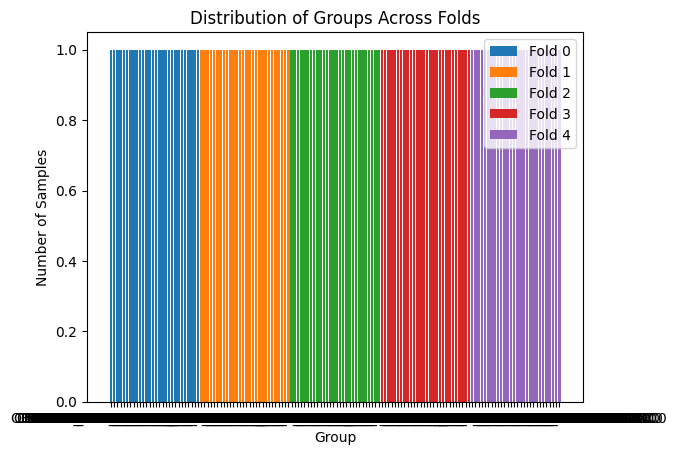

In [19]:

import matplotlib.pyplot as plt

# Count the number of samples per group per fold
fold_counts = {i: {} for i in range(5)}
for i, (train_idx, test_idx) in enumerate(splits):
    for group in np.unique(groups[test_idx]):
        fold_counts[i][group] = len(test_idx[groups[test_idx] == group])

# Plotting
fig, ax = plt.subplots()
for i in range(5):
    ax.bar(fold_counts[i].keys(), fold_counts[i].values(), label=f"Fold {i}")

ax.set_xlabel('Group')
ax.set_ylabel('Number of Samples')
ax.set_title('Distribution of Groups Across Folds')
ax.legend()

plt.show()


In [6]:
label_path = '/Users/ruijingyang/VSProjects/Orion-Cytox/src/cytotoxicity/data/compounds_lables.txt'
labelmaps = pd.read_csv(label_path, header=None, index_col=None)
labelmaps

,0,1
0,ORM-0012859_230810GA24B0,1
1,ORM-0013025_230810GA24B0,1
2,ORM-0013050_230810GA24B0,1
3,ORM-0006315_230810GA24B0,1
4,ORM-0012312_230810GA24B0,1
...,...,...
135,DMSO_240219GA24A0,0
136,DMSO_230817GA24A0,0
137,DMSO_230831GA24C0,0
138,DMSO_230831GA24A0,0


In [10]:
label_counts = labelmaps[1].value_counts()

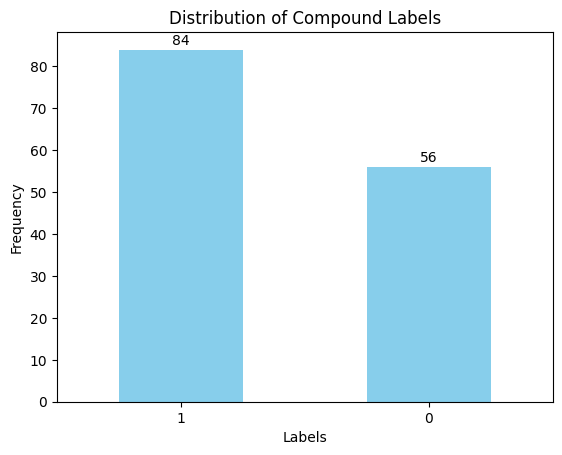

In [13]:
import matplotlib.pyplot as plt

ax = label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Compound Labels')

for p in ax.patches:
    # Calculate annotation position
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.5
    ax.annotate(f'{p.get_height()}', (x, y), ha='center', va='bottom')

plt.xticks(rotation=0)  # Rotates the labels on the x-axis to horizontal
plt.show()

In [36]:
name_label = pd.read_csv(label_path, index_col=0)
name_label

,Object Id,Barcode,Cytotoxic,Mitotoxic,moderately affects cell health,Non-toxic,compound_renamed
0,ORM-0012859,230810GA24B0,1,1,0,0,ORM-0012859_230810GA24B0
1,ORM-0013025,230810GA24B0,1,1,0,0,ORM-0013025_230810GA24B0
2,ORM-0013050,230810GA24B0,1,1,0,0,ORM-0013050_230810GA24B0
3,ORM-0006315,230810GA24B0,1,1,0,0,ORM-0006315_230810GA24B0
4,ORM-0012312,230810GA24B0,1,1,0,0,ORM-0012312_230810GA24B0
...,...,...,...,...,...,...,...
123,ORM-0001602,240219GA24B0,0,0,0,1,ORM-0001602_240219GA24B0
124,ORM-0364078,240219GA24B0,0,0,0,1,ORM-0364078_240219GA24B0
125,ORM-0013136,240219GA24B0,0,0,0,1,ORM-0013136_240219GA24B0
126,ORM-0293414,240219GA24B0,0,0,0,1,ORM-0293414_240219GA24B0


In [37]:
label_file = name_label['compound_renamed']
label_file

0      ORM-0012859_230810GA24B0
1      ORM-0013025_230810GA24B0
2      ORM-0013050_230810GA24B0
3      ORM-0006315_230810GA24B0
4      ORM-0012312_230810GA24B0
                 ...           
123    ORM-0001602_240219GA24B0
124    ORM-0364078_240219GA24B0
125    ORM-0013136_240219GA24B0
126    ORM-0293414_240219GA24B0
127    ORM-0293664_240219GA24B0
Name: compound_renamed, Length: 128, dtype: object

In [38]:
name_label['Non-toxic'] = name_label['Non-toxic'].replace({0: 1, 1: 0})
labels = name_label['Non-toxic']
labels

0      1
1      1
2      1
3      1
4      1
      ..
123    0
124    0
125    0
126    0
127    0
Name: Non-toxic, Length: 128, dtype: int64

In [39]:
save_label = pd.concat([label_file, labels], axis=1)

In [40]:
save_label

,compound_renamed,Non-toxic
0,ORM-0012859_230810GA24B0,1
1,ORM-0013025_230810GA24B0,1
2,ORM-0013050_230810GA24B0,1
3,ORM-0006315_230810GA24B0,1
4,ORM-0012312_230810GA24B0,1
...,...,...
123,ORM-0001602_240219GA24B0,0
124,ORM-0364078_240219GA24B0,0
125,ORM-0013136_240219GA24B0,0
126,ORM-0293414_240219GA24B0,0


In [41]:
save_label[save_label['compound_renamed'].str.contains("DMSO", na=False)]

,compound_renamed,Non-toxic
116,DMSO_230907GA24B0,0


In [43]:
save_label['Non-toxic'].value_counts()

Non-toxic
1    84
0    44
Name: count, dtype: int64

In [46]:
rename_list = save_label['compound_renamed'].tolist()
rename_list

['ORM-0012859_230810GA24B0',
 'ORM-0013025_230810GA24B0',
 'ORM-0013050_230810GA24B0',
 'ORM-0006315_230810GA24B0',
 'ORM-0012312_230810GA24B0',
 'ORM-0013348_230810GA24B0',
 'ORM-0140942_230810GA24C0',
 'ORM-0120988_230810GA24C0',
 'ORM-0178130_230810GA24C0',
 'ORM-0049279_230810GA24C0',
 'ORM-0149820_230810GA24C0',
 'ORM-0280627_230817GA24A0',
 'ORM-0283845_230817GA24A0',
 'ORM-0178132_230817GA24A0',
 'ORM-0293290_230817GA24A0',
 'ORM-0226420_230817GA24A0',
 'ORM-0260776_230817GA24A0',
 'ORM-0274325_230817GA24A0',
 'ORM-0293612_230817GA24B0',
 'ORM-0293831_230817GA24B0',
 'ORM-0294024_230817GA24C0',
 'ORM-0293899_230817GA24C0',
 'ORM-0293893_230817GA24C0',
 'ORM-0364075_230817GA24C0',
 'ORM-0272079_230817GA24C0',
 'ORM-0294172_230817GA24C0',
 'ORM-0292987_230824GA24B0',
 'ORM-0126653_230824GA24B0',
 'ORM-0293334_230824GA24B0',
 'ORM-0293149_230824GA24B0',
 'ORM-0293180_230831GA24A0',
 'ORM-0274325_230831GA24A0',
 'ORM-0283845_230831GA24A0',
 'ORM-0293290_230831GA24A0',
 'ORM-0280627_

In [44]:
count = 0  # 初始化计数器
compound_list = []
try:
    # os.listdir(directory_path) 返回指定路径下的文件和目录列表
    for name in os.listdir(compounds_path):
        # print(name)
        full_path = os.path.join(compounds_path, name)
        # os.path.isdir(full_path) 检查这个路径是否为目录
        # name.startswith('O') 检查目录名是否以 'O' 开头
        # if os.path.isdir(full_path) and name.startswith('O'):
        count += 1
        compound_list.append(name)
except Exception as e:
    print(f"An error occurred: {e}")

In [45]:
count

140

In [48]:
negatie_list = set(compound_list) - set(rename_list)
len(negatie_list)

12

In [53]:
list(negatie_list)

['DMSO_230810GA24B0',
 'DMSO_230907GA24A0',
 'DMSO_230817GA24C0',
 'DMSO_230817GA24B0',
 'DMSO_230824GA24B0',
 'DMSO_230810GA24C0',
 'DMSO_230831GA24B0',
 'DMSO_240219GA24A0',
 'DMSO_230817GA24A0',
 'DMSO_230831GA24C0',
 'DMSO_230831GA24A0',
 'DMSO_240219GA24B0']

In [50]:
neg_labels = [0] * len(negatie_list)

In [54]:
new_rows = pd.DataFrame({'compound_renamed': list(negatie_list),
                         'Non-toxic': neg_labels})

In [56]:
save_label = pd.concat([save_label, new_rows], axis=0, ignore_index=True)
save_label

,compound_renamed,Non-toxic
0,ORM-0012859_230810GA24B0,1
1,ORM-0013025_230810GA24B0,1
2,ORM-0013050_230810GA24B0,1
3,ORM-0006315_230810GA24B0,1
4,ORM-0012312_230810GA24B0,1
...,...,...
135,DMSO_240219GA24A0,0
136,DMSO_230817GA24A0,0
137,DMSO_230831GA24C0,0
138,DMSO_230831GA24A0,0


In [57]:
save_label['Non-toxic'].value_counts()

Non-toxic
1    84
0    56
Name: count, dtype: int64

In [58]:
save_label.to_csv('compounds_lables.txt', header=False, index=False, sep=',')

In [5]:
results_info = pd.read_csv(result_path, encoding='latin1') #, usecols=["Object Id", "Interpretation"])
results_info

,Unnamed: 0,Object Id,Highest Tested Concentration uM,LPC uM,Cell count IC50 uM,Cell count LEC uM,Nucleus Intensity EC50 uM,Nucleus Intensity LEC uM,Nucleus Area IC50 uM,Nucleus Area LEC uM,...,Lysosomal activity LEC uM,MitoArea EC50 uM,MitoArea LEC uM,MMP EC50 uM,MMP LEC uM,Barcode,Cytotoxic,Mitotoxic,moderately affects cell health,Non-toxic
0,TS230814-TX-HCA-02,ORM-0012859,200,113,29.3,35.6,28.4,20.06,22.4,20.06,...,1.254,>84.8,26.7,19.2,20.06,230810GA24B0,1,1,0,0
1,TS230814-TX-HCA-02,ORM-0013025,200,-,82.1,84.4,108.6,63.3,57.8,35.6,...,10.03,>200,>200,38.5,35.6,230810GA24B0,1,1,0,0
2,TS230814-TX-HCA-02,ORM-0013050,200,150,29.4,20.06,29.5,20.06,24.2,20.06,...,10.03,26,20.06,>112.5,63.3,230810GA24B0,1,1,0,0
3,TS230814-TX-HCA-02,ORM-0006315,200,-,109.3,63.3,>200,84.4,90.2,47.5,...,200,98.9,84.4,>200,200,230810GA24B0,1,1,0,0
4,TS230814-TX-HCA-02,ORM-0012312,200,-,13.4,20.06,32,20.06,13.9,10.03,...,>200,17.6,20.06,>200,2.508,230810GA24B0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,TS240221-TX-HCA-02,ORM-0001602,200,-,>200,>200,>200,>200,>200,>200,...,>200,>200,200,>200,>200,240219GA24B0,0,0,0,1
124,TS240221-TX-HCA-02,ORM-0364078,200,-,>200,200,>200,>200,>200,>200,...,>200,>200,>200,>200,>200,240219GA24B0,0,0,0,1
125,TS240221-TX-HCA-02,ORM-0013136,200,-,>200,>200,>200,84.4,>200,>200,...,>200,>200,>200,>200,>200,240219GA24B0,0,0,0,1
126,TS240221-TX-HCA-02,ORM-0293414,50,-,>50,50,>50,>50,>50,>50,...,>50,>50,>50,>50,>50,240219GA24B0,0,0,0,1


In [6]:
list1 = results_info['Object Id']

In [23]:
len(pd.unique(results_info['Object Id']))

69

In [10]:
value_counts = results_info['Object Id'].value_counts()
repeated_elements = value_counts[value_counts > 1]

print("出现次数超过一次的元素及其次数：")
print(repeated_elements)

出现次数超过一次的元素及其次数：
Object Id
ORM-0293923    4
ORM-0013271    4
ORM-0001602    4
ORM-0272079    3
ORM-0226420    3
ORM-0014500    3
ORM-0364082    3
ORM-0294172    3
ORM-0364075    3
ORM-0293893    3
ORM-0293899    3
ORM-0294024    3
ORM-0260776    3
ORM-0292997    3
ORM-0120988    3
ORM-0293290    2
ORM-0293180    2
ORM-0293561    2
ORM-0140940    2
ORM-0013739    2
ORM-0293600    2
ORM-0293604    2
ORM-0293667    2
ORM-0293771    2
ORM-0293819    2
ORM-0293830    2
ORM-0006484    2
ORM-0140942    2
ORM-0178132    2
ORM-0293499    2
ORM-0178130    2
ORM-0049279    2
ORM-0283845    2
ORM-0274325    2
ORM-0293612    2
ORM-0293831    2
ORM-0280627    2
ORM-0149820    2
ORM-0012859    2
ORM-0293107    2
ORM-0364078    2
Name: count, dtype: int64


In [11]:
mapping = results_info[["Object Id"]]
label = results_info.iloc[:, -5:]
label

,Barcode,Cytotoxic,Mitotoxic,moderately affects cell health,Non-toxic
0,230810GA24B0,1,1,0,0
1,230810GA24B0,1,1,0,0
2,230810GA24B0,1,1,0,0
3,230810GA24B0,1,1,0,0
4,230810GA24B0,1,1,0,0
...,...,...,...,...,...
123,240219GA24B0,0,0,0,1
124,240219GA24B0,0,0,0,1
125,240219GA24B0,0,0,0,1
126,240219GA24B0,0,0,0,1


In [12]:
compound_label_mapping = pd.concat([mapping, label], axis=1)
compound_label_mapping

,Object Id,Barcode,Cytotoxic,Mitotoxic,moderately affects cell health,Non-toxic
0,ORM-0012859,230810GA24B0,1,1,0,0
1,ORM-0013025,230810GA24B0,1,1,0,0
2,ORM-0013050,230810GA24B0,1,1,0,0
3,ORM-0006315,230810GA24B0,1,1,0,0
4,ORM-0012312,230810GA24B0,1,1,0,0
...,...,...,...,...,...,...
123,ORM-0001602,240219GA24B0,0,0,0,1
124,ORM-0364078,240219GA24B0,0,0,0,1
125,ORM-0013136,240219GA24B0,0,0,0,1
126,ORM-0293414,240219GA24B0,0,0,0,1


In [13]:
compound_label_mapping['compound_renamed'] = compound_label_mapping['Object Id'] + '_' + compound_label_mapping['Barcode']

In [14]:
compound_label_mapping.to_csv('compound_label_barcode_mapping.csv', sep=',', encoding='utf-8')

In [15]:
rename_list = compound_label_mapping['compound_renamed']

In [14]:
len(compound_list)

70

In [16]:
missing_compounds = set(compound_list) - set(rename_list)

In [17]:
len(missing_compounds)

2

In [18]:
missing_compounds

{'ORM-0371350_230824GA24B0', 'ORM-0371353_230824GA24B0'}

In [19]:
missing_compounds2 = set(rename_list) - set(compound_list)
missing_compounds2

{'DMSO_230907GA24B0'}

In [22]:
'DMSO_230907GA24B0' in missing_compounds2

True

In [23]:
'DMSO_230907GA24B0' in  compound_list

False